## 各種CSVをDataFrameに読みこむ

リレーショナルデータベースのように工程ごとにCSVを分けて正規化しています。  
レシピ、製造、試験とそれぞれの工程ごとに若干テーブルの構造が異なっており、レシピと試験工程に関しては1工程につき複数のテーブルを抱えています。  

- 材料や機器などを保持するマスタ情報
  - ゴム
  - カーボンブラック
  - 製造元
  - 試験車両
- レシピ工程
  - レシピ全体 (*_recipes.csv)
  - サブレシピ全体 (*_sub_recipes.csv) ← サブレシピを設定していない場合は出力されません
  - 材料・量情報 (*_material_amounts.csv)
- 製造工程
- 試験工程
  - 試験条件 (*_conditions.csv)
  - 試験結果 (*_result.csv)

材料・量情報とレシピについての補足
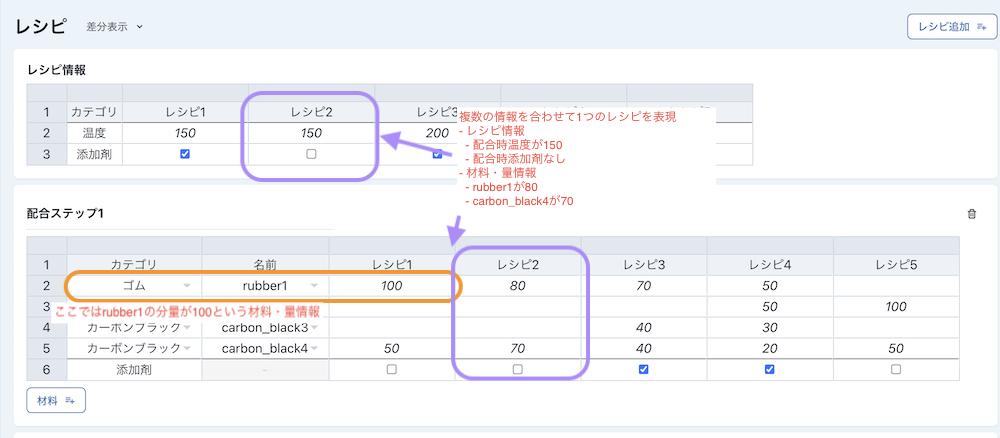


In [15]:
from libs.read_csv import csv_to_df, key_to_display_name
from libs.combine import merge_columns_df
import pandas as pd

# マスタの読み込み
rubber_df = csv_to_df('./export/theme_b_rubber.csv')
carbon_black_df = csv_to_df('./export/theme_b_carbon_black.csv')
maker_df = csv_to_df('./export/theme_b_maker.csv')
vehicle_df = csv_to_df('./export/theme_b_vehicle.csv')
# レシピ工程の読み込み
recipe_df = csv_to_df('./export/theme_b_recipe_recipes.csv')
subrecipe_df = csv_to_df('./export/theme_b_recipe_sub_recipes.csv')
material_amount_df = csv_to_df('./export/theme_b_recipe_material_amounts.csv')
# 製造工程の読み込み
make_form_df = csv_to_df('./export/theme_b_make_form.csv')
# 試験工程の読み込み
breaking_condition_df = csv_to_df('./export/theme_b_breaking_evaluation_conditions.csv')
breaking_result_df = csv_to_df('./export/theme_b_breaking_evaluation_results.csv')

print('-- 読み取ったデータはprintで確認可能 --')
print(rubber_df)

print('-- 必要なパラメタのみ抽出することも可能 --')
print(rubber_df[['theme_b_rubber.name', 'theme_b_rubber.param2']])

print('-- そのまま読みづらい場合はヘッダを日本語へ変換することも可能 --')
key_mapper = key_to_display_name(['./export/theme_b_rubber.csv'])
print(rubber_df.rename(columns=key_mapper))

-- 読み取ったデータはprintで確認可能 --
                    theme_b_rubber.__id theme_b_rubber.name  \
2  aa610527-eb34-4430-bbc0-fb1bbfb3f27d             rubber1   
3  df2225e3-67d4-4670-9dcb-5bfd0e42bc7b             rubber2   
4  00c40efd-3a6b-46fd-9d9b-89c3af0b277c             rubber3   
5  5c7bcbc8-9dd6-4757-b29d-c3643c07612a             rubber4   
6  4f581462-34b2-40b5-9488-0de1b17ec7de             rubber5   

   theme_b_rubber.param1  theme_b_rubber.param2  \
2                   50.0                   12.0   
3                   80.0                   11.5   
4                   88.0                   22.1   
5                   90.0                   18.6   
6                   56.3                   11.0   

                   theme_b_rubber.maker  
2  ef47e88b-c316-4503-9e62-1597778a72c0  
3  1ac9039b-ac81-4b9c-8f22-3c285adcb508  
4  838ec269-6d25-4f14-81bd-b09e14da4ade  
5  24cbf099-108a-4ce1-a6c9-4f96e636734d  
6  eacb7a51-9eb4-45e1-932c-72711fea02c1  
-- 必要なパラメタのみ抽出することも可能 --
  theme_b_r

## DataFrame同士を結合する

DataFrameには正規化されたデータしか入っていないため、結合や集計を行い処理を行える状態に持っていきます。  
各DataFrameのリレーションは以下の図に示しています。  
本サンプルではmaterial_amount_dfを起点に結合していますが、希望の完成形によって起点にするもの、結合順序を決めてください。  

```mermaid
---
title: DataFarame間の関係
---
erDiagram
    maker_df }|--o{ rubber_df : uses
    maker_df }|--o{ carbon_black_df : uses
    rubber_df }|--o{ material_amount_df : uses
    carbon_black_df }|--o{ material_amount_df : uses
    material_amount_df }|--o| sub_recipe_df: contains
    sub_recipe_df }o--|| recipe_df: contains
    recipe_df ||--o{ make_form_df: uses
    make_form_df ||--o{ breaking_result_df: uses
    breaking_condition_df ||--o{ breaking_result_df: uses
    vehicle_df ||--o{ breaking_condition_df: uses

```

In [34]:
from libs.combine import merge_columns_df

# ======
# マスタ情報とレシピ情報を結合
# ======

# 材料・量のペアと材料マスタのパラメタを結合
df = pd.merge(
    material_amount_df,
    rubber_df,
    left_on='theme_b_recipe_material_amounts.__master_id',
    right_on='theme_b_rubber.__id',
    how='left'
)
df = pd.merge(
    df,
    carbon_black_df,
    left_on='theme_b_recipe_material_amounts.__master_id',
    right_on='theme_b_carbon_black.__id',
    how='left'
)

# メーカーマスタのパラメタを結合
"""
'theme_b_carbon_black.maker', 'theme_b_rubber.maker' それぞれに対して結合を行うと、makerキーが重複してしまい、片方が上書きされてしまう。
回避のため先に列を結合しておく。
"""
merge_columns_df(df, ['theme_b_carbon_black.maker', 'theme_b_rubber.maker'], 'theme_b_maker.__id')

df = pd.merge(
    df,
    maker_df,
    left_on='theme_b_maker.__id',
    right_on='theme_b_maker.__id',
    how='left'
)

# 材料・量とレシピのパラメタを結合
df = pd.merge(
    df,
    subrecipe_df,
    left_on='theme_b_recipe_material_amounts.__sub_recipe_id',
    right_on='theme_b_recipe_sub_recipes.__id',
    how='left'
)
df = pd.merge(
    df,
    recipe_df,
    left_on='theme_b_recipe_recipes.__id',
    right_on='theme_b_recipe_recipes.__id',
    how='left'
)

print(df[['theme_b_rubber.name', 'theme_b_carbon_black.name', 'theme_b_recipe_material_amounts.amount', 'theme_b_maker.name']])

   theme_b_rubber.name theme_b_carbon_black.name  \
0              rubber1                       NaN   
1                  NaN             carbon_black4   
2              rubber1                       NaN   
3                  NaN             carbon_black4   
4              rubber1                       NaN   
5                  NaN             carbon_black4   
6                  NaN             carbon_black3   
7              rubber1                       NaN   
8                  NaN             carbon_black4   
9                  NaN             carbon_black3   
10             rubber2                       NaN   
11                 NaN             carbon_black4   
12             rubber2                       NaN   
13             rubber2                       NaN   
14                 NaN             carbon_black2   
15             rubber2                       NaN   
16                 NaN             carbon_black1   
17             rubber2                       NaN   
18          

In [35]:
# ======
# 製造工程や試験工程と結合
# ======

# レシピ工程:成形工程 = 1:n なので、right join で結合
df = pd.merge(
    df,
    make_form_df,
    left_on='theme_b_recipe_recipes.__id',
    right_on='dependencyDevStep.__id',
    how='right'
)

df = pd.merge(
    df,
    breaking_result_df,
    left_on='theme_b_make_form.__id',
    right_on='make_form.__id',
    how='right'
)

df = pd.merge(
    df,
    breaking_condition_df,
    left_on='theme_b_breaking_evaluation_results.condition_id',
    right_on='theme_b_breaking_evaluation_conditions.__id',
    how='left'
)

df = pd.merge(
    df,
    vehicle_df,
    left_on='theme_b_breaking_evaluation_conditions.vehicle',
    right_on='theme_b_vehicle.__id',
    how='left'
)

# 結合した全てのDataFrameのキーを保持する
print(df.columns)

Index(['theme_b_recipe_material_amounts.__id',
       'theme_b_recipe_material_amounts.__sub_recipe_id',
       'theme_b_recipe_material_amounts.__master_name',
       'theme_b_recipe_material_amounts.__master_id',
       'theme_b_recipe_material_amounts.amount', 'theme_b_rubber.__id',
       'theme_b_rubber.name', 'theme_b_rubber.param1', 'theme_b_rubber.param2',
       'theme_b_carbon_black.__id', 'theme_b_carbon_black.name',
       'theme_b_carbon_black.param1', 'theme_b_carbon_black.param2',
       'theme_b_maker.__id', 'theme_b_maker.name',
       'theme_b_recipe_sub_recipes.__id', 'theme_b_recipe_recipes.__id',
       'theme_b_recipe_sub_recipes.__name',
       'theme_b_recipe_sub_recipes.additive',
       'theme_b_recipe_recipes.__recipe_name', 'project.__id',
       'theme_b_recipe_recipes.temp', 'theme_b_recipe_recipes.additive',
       'theme_b_make_form.__id', 'dependencyDevStep.__id',
       'theme_b_make_form.tread_width', 'theme_b_make_form.carcass_length',
       'theme_

## データを可視化する

結合したデータを様々なライブラリを用いて可視化することも可能です。

<Figure size 1000x600 with 0 Axes>

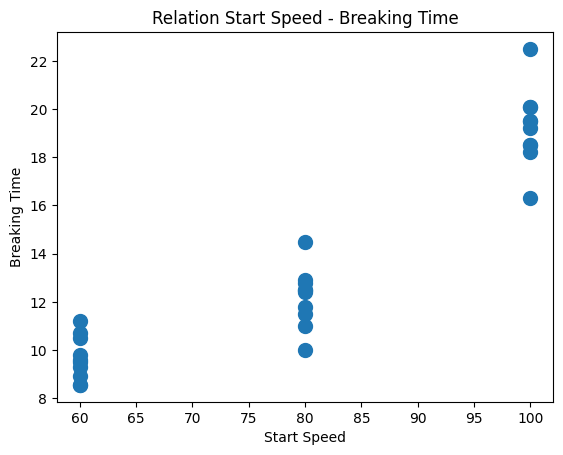

In [36]:
import matplotlib.pyplot as plt

plot_df = pd.merge(
    breaking_result_df,
    breaking_condition_df,
    left_on='theme_b_breaking_evaluation_results.condition_id',
    right_on='theme_b_breaking_evaluation_conditions.__id',
    how='left'
)

# グラフの描画
plt.figure(figsize=(10, 6))
plot_df.plot.scatter(x='theme_b_breaking_evaluation_conditions.speed', y='theme_b_breaking_evaluation_results.duration', s=100)
plt.title('Relation Start Speed - Breaking Time')
plt.xlabel('Start Speed')
plt.ylabel('Breaking Time')
plt.show()

## 前処理と学習

機械学習にかける前に前処理を行い、適切なモデル学習を行いましょう。
- 目的変数と説明変数を絞る
- 欠損値を埋める
- ラベルエンコード etc.

In [37]:
import numpy as np

# 材料・量情報では、全てのカテゴリの分量が同じカラムに入っているためカラムを分ける

conditions = [
    # ゴムを材料としている材料・量情報
    df['theme_b_recipe_material_amounts.__master_name'] == 'theme_b_rubber',
    # カーボンブラックを材料としている材料・量情報
    df['theme_b_recipe_material_amounts.__master_name'] == 'theme_b_carbon_black',
]

df['rubber_amount'] = (np.select(conditions, [df['theme_b_recipe_material_amounts.amount'], np.nan], default=np.nan)).astype(float)
df['carbon_black_amount'] = np.select(conditions, [np.nan, df['theme_b_recipe_material_amounts.amount']], default=np.nan).astype(float)
print(df[['theme_b_recipe_material_amounts.__master_name', 'rubber_amount', 'carbon_black_amount']])

    theme_b_recipe_material_amounts.__master_name  rubber_amount  \
0                                  theme_b_rubber          100.0   
1                            theme_b_carbon_black            NaN   
2                                  theme_b_rubber           30.0   
3                            theme_b_carbon_black            NaN   
4                                  theme_b_rubber           80.0   
..                                            ...            ...   
109                                theme_b_rubber           50.0   
110                          theme_b_carbon_black            NaN   
111                                theme_b_rubber          100.0   
112                                theme_b_rubber           20.0   
113                          theme_b_carbon_black            NaN   

     carbon_black_amount  
0                    NaN  
1                   50.0  
2                    NaN  
3                   10.0  
4                    NaN  
..                   

In [38]:
# 訓練するためにデータを集計する

# カラムのキーとdtypeを取得し、集計関数と紐付ける
columns = df.columns
dtypes = df.dtypes.astype(str).to_dict()

# 数値は平均値、それ以外は最頻値で埋める
agg_mapper = {
    'float64': 'mean',
    'bool': lambda x: x.mode().iloc[0],
    'object': lambda x: x.mode().iloc[0],
}

agg_funcs = { c: agg_mapper[dtypes[c]] for c in columns}

print(agg_funcs)

{'theme_b_recipe_material_amounts.__id': <function <lambda> at 0x316c77100>, 'theme_b_recipe_material_amounts.__sub_recipe_id': <function <lambda> at 0x316c77100>, 'theme_b_recipe_material_amounts.__master_name': <function <lambda> at 0x316c77100>, 'theme_b_recipe_material_amounts.__master_id': <function <lambda> at 0x316c77100>, 'theme_b_recipe_material_amounts.amount': <function <lambda> at 0x316c77100>, 'theme_b_rubber.__id': <function <lambda> at 0x316c77100>, 'theme_b_rubber.name': <function <lambda> at 0x316c77100>, 'theme_b_rubber.param1': 'mean', 'theme_b_rubber.param2': 'mean', 'theme_b_carbon_black.__id': <function <lambda> at 0x316c77100>, 'theme_b_carbon_black.name': <function <lambda> at 0x316c77100>, 'theme_b_carbon_black.param1': 'mean', 'theme_b_carbon_black.param2': 'mean', 'theme_b_maker.__id': <function <lambda> at 0x316c77100>, 'theme_b_maker.name': <function <lambda> at 0x316c77100>, 'theme_b_recipe_sub_recipes.__id': <function <lambda> at 0x316c77100>, 'theme_b_re

In [39]:
# 実験条件ごとに丸める
grouped = df.groupby('theme_b_breaking_evaluation_conditions.__id').agg(agg_funcs)

print('--- 集計前 ---')
print(df[['theme_b_breaking_evaluation_conditions.__id', 'theme_b_breaking_evaluation_results.duration', 'rubber_amount', 'carbon_black_amount']])
print('--- 集計後 ---')
print(grouped[['theme_b_breaking_evaluation_conditions.__id', 'theme_b_breaking_evaluation_results.duration', 'rubber_amount', 'carbon_black_amount']])

--- 集計前 ---
    theme_b_breaking_evaluation_conditions.__id  \
0          43dcdd39-f9ed-456c-b1bc-17918e866061   
1          43dcdd39-f9ed-456c-b1bc-17918e866061   
2          43dcdd39-f9ed-456c-b1bc-17918e866061   
3          43dcdd39-f9ed-456c-b1bc-17918e866061   
4          43dcdd39-f9ed-456c-b1bc-17918e866061   
..                                          ...   
109        35960a3e-5d72-482b-82ae-f8b068a65a4d   
110        35960a3e-5d72-482b-82ae-f8b068a65a4d   
111        35960a3e-5d72-482b-82ae-f8b068a65a4d   
112        35960a3e-5d72-482b-82ae-f8b068a65a4d   
113        35960a3e-5d72-482b-82ae-f8b068a65a4d   

     theme_b_breaking_evaluation_results.duration  rubber_amount  \
0                                             9.8          100.0   
1                                             9.8            NaN   
2                                             9.8           30.0   
3                                             9.8            NaN   
4                                  

In [40]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 説明変数と目的変数の分離
X = grouped[[
    'rubber_amount',
    'carbon_black_amount',
    'theme_b_rubber.param1',
    'theme_b_rubber.param2',
    'theme_b_carbon_black.param1',
    'theme_b_carbon_black.param2',
    'theme_b_vehicle.weight',
    'theme_b_make_form.tread_width',
    'theme_b_breaking_evaluation_conditions.speed',
    'theme_b_breaking_evaluation_results.uneven_wear'
]]
y = grouped[['theme_b_breaking_evaluation_results.duration']]

print('--- Xのキー ---')
print(X.columns)

print('--- yのキー ---')
print(y.columns)

--- Xのキー ---
Index(['theme_b_rubber.param1', 'theme_b_rubber.param2',
       'theme_b_carbon_black.param1', 'theme_b_carbon_black.param2',
       'theme_b_vehicle.weight', 'theme_b_make_form.tread_width',
       'theme_b_breaking_evaluation_conditions.speed',
       'theme_b_breaking_evaluation_results.uneven_wear'],
      dtype='object')
--- yのキー ---
Index(['theme_b_breaking_evaluation_results.duration'], dtype='object')


In [41]:
# 訓練データとテストデータに分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのデータセットに変換
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# ハイパーパラメータの設定
params = {
    "objective": "regression",
    "metric": "mse",
    "max_depth": 20,
    "min_data_in_bin": 3,
    "min_data_in_leaf": 3,
    "verbose": 0
  }

# モデルの訓練
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=3)

# 予測
y_pred = model.predict(X_test)

# 精度の計算
mse: float = mean_squared_error(y_test, y_pred)
print(mse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
71.72752724512898
